In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import sparse

Read raw data

In [ ]:
anime_ratings_df = pd.read_csv("/content/drive/MyDrive/DSBA6156_APML/rating.csv")

In [ ]:
anime_ratings = anime_ratings_df.loc[anime_ratings_df.rating != -1].reset_index()[['user_id','anime_id','rating']]

In [ ]:
def encode_column(column):
    """ Encodes a pandas column with continous IDs"""
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

In [ ]:
def encode_df(anime_df):
    """Encodes rating data with continuous user and anime ids"""

    anime_ids, anime_df['anime_id'], num_anime = encode_column(anime_df['anime_id'])
    user_ids, anime_df['user_id'], num_users = encode_column(anime_df['user_id'])
    return anime_df, num_users, num_anime, user_ids, anime_ids

In [ ]:
anime_ratings = anime_ratings.reset_index()[['user_id', 'anime_id', 'rating']]

In [ ]:
anime_df, num_users, num_anime, user_ids, anime_ids = encode_df(anime_ratings)
print("Number of users :", num_users)
print("Number of anime :", num_anime)
anime_df.head()

Number of users : 69600
Number of anime : 9927


,user_id,anime_id,rating
0,0,0,10
1,0,1,10
2,0,2,10
3,0,3,10
4,1,4,10


In [ ]:
anime_df.shape

(6337241, 3)

In [ ]:
def create_sparse_matrix(df, rows, cols, column_name="rating"):
    """ Returns a sparse utility matrix"""
    return sparse.csc_matrix((df[column_name].values,(df['user_id'].values, df['anime_id'].values)),shape=(rows, cols))

In [ ]:
anime_df, num_users, num_anime, user_ids, anime_ids = encode_df(anime_ratings)
Y = create_sparse_matrix(anime_df, num_users, num_anime)

In [ ]:
Y.shape

(69600, 9927)

In [ ]:
Y.todense()

matrix([[10, 10, 10, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 6,  0,  9, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 9,  0,  9, ...,  0,  0,  0],
        [ 9,  0,  0, ...,  0,  0,  0]])

## Dimension reduction using Non-Negative Matrix Factorization (NMF)

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(Y)
H = model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
W.shape

(69600, 100)

In [ ]:
H.shape

(100, 9927)

## Supervised learning

In [ ]:
df = anime_df.sample(n=10000, random_state=1)

In [ ]:
train_idx, test_idx = train_test_split(df, test_size=0.2)

In [ ]:
def create_features(vec):
    user, item = vec
    X = np.concatenate([W[user,:],H[:,item]])
    return pd.Series(X)

In [ ]:
train_X, train_y = train_idx.apply(lambda x: create_features(x[['user_id','anime_id']]), axis = 1), train_idx['rating']

In [ ]:
test_X, test_y = test_idx.apply(lambda x: create_features(x[['user_id','anime_id']]), axis = 1), test_idx['rating']

In [ ]:
train_X.shape

(8000, 200)

In [ ]:
train_y.shape

(8000,)

### testing

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {}

In [ ]:
grid= GridSearchCV(LinearRegression(), param_grid, return_train_score=True)
grid.fit(train_X, train_y)

GridSearchCV(estimator=LinearRegression(), param_grid={},
             return_train_score=True)

In [ ]:
from sklearn.model_selection import cross_validate
cross_validate(LinearRegression(), train_X, train_y)

{'fit_time': array([0.09396076, 0.09514666, 0.09512186, 0.13084769, 0.10038042]),
 'score_time': array([0.00554347, 0.00544   , 0.00553393, 0.00554156, 0.00565791]),
 'test_score': array([0.13625998, 0.13040698, 0.10848343, 0.1672209 , 0.14247805])}

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
cross_validate(GradientBoostingRegressor(), train_X, train_y)

{'fit_time': array([15.80497217, 14.37457705, 15.71427941, 14.45271063, 14.50945187]),
 'score_time': array([0.00859857, 0.00780368, 0.00783777, 0.0083952 , 0.00809216]),
 'test_score': array([0.17513367, 0.17699808, 0.17412796, 0.18901858, 0.20147237])}

In [ ]:
grid.best_score_

0.1369698677752092

In [ ]:
grid.score(test_X, test_y)

0.11798584277340451

## Unsupervised learning

### k-means model to predict ratings

### training

In [ ]:
from sklearn.cluster import KMeans
Kn =KMeans(n_clusters=5, random_state=3)
Kn.fit(train_X)

KMeans(n_clusters=5, random_state=3)

In [ ]:
Kn.labels_

array([0, 3, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
import numpy as np
average = []
for i in range(5):
  print(np.mean(train_y[Kn.labels_ == i]))
  average.append(np.mean(train_y[Kn.labels_ == i]))

7.851095685313734
8.972222222222221
7.823529411764706
7.292418772563177
8.891304347826088


In [ ]:
inertia = []
for k in range(5,100,5):
  Kn = KMeans(n_clusters=k,random_state=0)
  Kn.fit(train_X)
  print(Kn.inertia_)
  inertia.append(Kn.inertia_)

4821482.567510775
3671470.492982785
3022742.698029956
2550606.40183274
2092103.5412925263
1802246.253646384
1567356.8495523094
1384693.4469288932
1205208.5740367633
1073069.6532602403
952149.2580535006
874429.2877298851
810491.8204194647
759424.6249498797
709985.974070684
666357.0516342649
628403.871463646
601123.6623440403
567509.8766342348


### testing

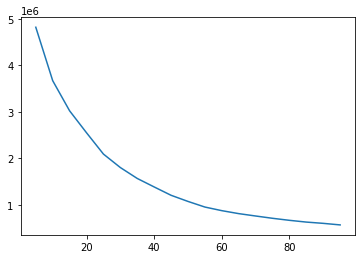

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(5,100,5),inertia)

In [ ]:
Kn.predict(test_X).max()

94

### Test on unknown data. Predict the rating of user_id == 1 on anime_id==1.

In [ ]:
pred = []
for i in Kn.predict(test_X):
  pred.append(average[1])

In [ ]:
from sklearn.metrics import r2_score
r2_score(test_y,pred)

-0.5288699224700582

###  Visualization

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


([], <a list of 0 Text major ticklabel objects>)

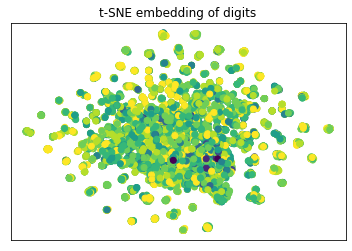

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
train_X_tsne = TSNE().fit_transform(train_X)
plt.scatter(train_X_tsne[:, 0],train_X_tsne[:, 1],c=train_y)
plt.title("t-SNE embedding of digits")
plt.xticks(())
plt.yticks(())


In [ ]:
train_X_tsne.shape

(8000, 2)